In [1]:
import sys
#sys.path.append("C:/Users/Surface/Documents/repos/playground")
sys.path.append("/home/peterhacker/Documents/phRepo/playground")

from Oceanmodel.policy_ve import *
from Oceanmodel.stateupdates_ve import *
from Oceanmodel.engine import *


In [2]:
MONTE_CARLO_RUNS = 1
sim_length = 832 #CHANGE IN behavior_ve.py too!!!

In [4]:
#system_params = create_par_sweep(system_params)
## Simulation 1
#sim_config = config_sim({
#    "N": MONTE_CARLO_RUNS,
#    "T": range(sim_length),
#    "M": system_params
#})
#
#psubs = generate_psubs_all()
#psubs = generate_psubs_LazyLocking_PerfectActivationVotingVolume()
#psubs = generate_psubs_SmartLocking_PerfectActivationVotingVolume()

#for i in range(len(psubs)):
#    experiment.append_configs(
#        initial_state = initial_state,
#        partial_state_update_blocks = psubs[i],
#        sim_configs = sim_config
#    )

#experiment.append_configs(
#    initial_state = initial_state,
#    partial_state_update_blocks = psubs[1],
#    sim_configs = sim_config
#)

# For full model runs & Analysis

In [4]:
# Batch params
system_params = create_par_sweep(system_params)
psubs = generate_psubs_stoch()

batch_size = #4
batches = #4

assert batch_size*batches == len(system_params['minlock_amt'])

for i in range(len(psubs)):
    for j in range(batches):
        
        system_params_batch = {}
        
        for key in system_params.keys():
            system_params_batch[key] = system_params[key][j*batch_size:(j+1)*batch_size]
        
        del configs[:]
        
        sim_config = config_sim({
            "N": MONTE_CARLO_RUNS,
            "T": range(sim_length),
            "M": system_params_batch
        })

        experiment.append_configs(
            initial_state = initial_state,
            partial_state_update_blocks = psubs[i],
            sim_configs = sim_config
        )

        exec_context = ExecutionContext()
        simulation = Executor(exec_context=exec_context, configs=configs)
        raw_result, tensor_field, sessions = simulation.execute()

        simulation_result = pd.DataFrame(raw_result)
        df_write_out = post_process(simulation_result)
        df_write_out.to_csv('results/second_sim_batch_'+str(j)+'.csv')


psub assumptions: Locking: p_lock_stoch, Voting: p_vote_stoch, Consumption: p_data_asset_consumed_stoch

                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (832, 19, 4, 10)
Execution Method: local_simulations
SimIDs   : [0, 0, 0, 0]
SubsetIDs: [0, 1, 2, 3]
Ns       : [0, 1, 2, 3]
ExpIDs   : [0, 0, 0, 0]
Execution Mode: parallelized
Total execution time: 274.71s

                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (832, 19, 4, 10)
Execution Method: local_s

: 

: 

In [4]:
# batch psubs

psubs_1 = generate_psubs_LazyLocking_PerfectActivationVotingVolume()
for i in range(len(psubs_1)):
    del configs[:]

    experiment.append_configs(
        initial_state = initial_state,
        partial_state_update_blocks = psubs_1[i],
        sim_configs = sim_config
    )

    exec_context = ExecutionContext()
    simulation = Executor(exec_context=exec_context, configs=configs)
    raw_result, tensor_field, sessions = simulation.execute()

    simulation_result = pd.DataFrame(raw_result)

    simulation_result['simulation'] = i
    simulation_result.to_csv('results/LL_PAVV_simulation_'+str(i)+'.csv')

psubs_2 = generate_psubs_SmartLocking_PerfectActivationVotingVolume()
for i in range(len(psubs_2)):
    del configs[:]

    experiment.append_configs(
        initial_state = initial_state,
        partial_state_update_blocks = psubs_2[i],
        sim_configs = sim_config
    )

    exec_context = ExecutionContext()
    simulation = Executor(exec_context=exec_context, configs=configs)
    raw_result, tensor_field, sessions = simulation.execute()

    simulation_result = pd.DataFrame(raw_result)

    simulation_result['simulation'] = i
    simulation_result.to_csv('results/SL_PAVV_simulation_'+str(i)+'.csv')

psub assumptions: Locking: p_lock_2, Voting: p_vote_5, Consumption: p_data_asset_consumed_1
psub assumptions: Locking: p_lock_2, Voting: p_vote_5, Consumption: p_data_asset_consumed_2
psub assumptions: Locking: p_lock_2, Voting: p_vote_5, Consumption: p_data_asset_consumed_3

                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (832, 12, 5, 10)
Execution Method: local_simulations
SimIDs   : [0, 0, 0, 0, 0]
SubsetIDs: [0, 1, 2, 3, 4]
Ns       : [0, 1, 2, 3, 4]
ExpIDs   : [0, 0, 0, 0, 0]
Execution Mode: parallelized
Total execution time: 175.33s

                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/ 

In [3]:
# read csv files to data frame

simulation_result = pd.DataFrame()

for i in range(len(psubs_1 + psubs_2)):
    try:
        df = pd.read_csv('results/LL_PAVV_simulation_' + str(i) + '.csv')
        df['experiment'] = 'LL'
    except:
        df = pd.read_csv('results/SL_PAVV_simulation_' + str(i-3) + '.csv')
        df['experiment'] = 'SL'

    simulation_result = pd.concat([simulation_result, df])

simulation_result.groupby(['experiment', 'simulation', 'subset', 'run']).count()['timestep']

NameError: name 'psubs_1' is not defined

In [60]:
# read csv files to data frame

simulation_result = pd.DataFrame()
file_prefix = 'second_big_sim_parambatch_'

for j in range(3):
    for i in range(36):
        try:
            df = pd.read_csv('results/' + file_prefix + str(i) + 'psubsbatch_'+ str(j) +'.csv')
            df['subset'] = df['subset'] + i * 2 + j * 72
            #print('results/' + file_prefix + str(i) + 'psubsbatch_'+ str(j) +'.csv')
            
        except:
            continue
        simulation_result = pd.concat([simulation_result, df])


df_p = simulation_result.copy()

In [43]:
df_p.groupby(['simulation', 'subset']).count()['timestep']

simulation  subset
0           0         832
            1         832
            2         832
            3         832
            4         832
                     ... 
            151       832
            152       832
            153       832
            154       832
            155       832
Name: timestep, Length: 118, dtype: int64

# For Ad-Hoc Runs & Analysis

In [1]:
import sys
#sys.path.append("C:/Users/Surface/Documents/repos/playground")
sys.path.append("/home/peterhacker/Documents/phRepo/playground")

from Oceanmodel.policy_ve import *
from Oceanmodel.stateupdates_ve import *
from Oceanmodel.engine import *


In [2]:
MONTE_CARLO_RUNS = 1
sim_length = 10 #832 #CHANGE IN behavior_ve.py too!!!

system_params = create_par_sweep(system_params)

sim_config = config_sim({
    "N": MONTE_CARLO_RUNS,
    "T": range(sim_length),
    "M": system_params
})

#psubs = generate_psubs_all()
#psubs = generate_psubs_LazyLocking_PerfectActivationVotingVolume()
#psubs = generate_psubs_SmartLocking_PerfectActivationVotingVolume()
psubs = generate_psubs_stoch()


#for i in range(len(psubs)):
#    experiment.append_configs(
#        initial_state = initial_state,
#        partial_state_update_blocks = psubs[i],
#        sim_configs = sim_config
#    )

experiment.append_configs(
    initial_state = initial_state,
    partial_state_update_blocks = psubs[0],
    sim_configs = sim_config
)

psub assumptions: Locking: p_lock_stoch, Voting: p_vote_stoch, Consumption: p_data_asset_consumed_stoch


In [3]:
exec_context = ExecutionContext()

simulation = Executor(exec_context=exec_context, configs=configs)

raw_result, tensor_field, sessions = simulation.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (10, 19, 27, 10)
Execution Method: local_simulations
SimIDs   : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
SubsetIDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
Ns       : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
ExpIDs   : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Execution Mode: parallelized
Total execution time: 3.56s


In [4]:
# Get df
simulation_result = pd.DataFrame(raw_result)
#simulation_result

## save simulation results to csv
#simulation_result.to_csv('simulation_result.csv')


In [5]:
simulation_result.groupby(['simulation', 'subset', 'run']).count()['timestep']

simulation  subset  run
0           0       1      41
            1       1      41
            2       2      41
            3       3      41
            4       4      41
            5       5      41
            6       6      41
            7       7      41
            8       8      41
            9       9      41
            10      10     41
            11      11     41
            12      12     41
            13      13     41
            14      14     41
            15      15     41
            16      16     41
            17      17     41
            18      18     41
            19      19     41
            20      20     41
            21      21     41
            22      22     41
            23      23     41
            24      24     41
            25      25     41
            26      26     41
Name: timestep, dtype: int64

In [2]:
# Analysis and plotting modules
import pandas as pd
import numpy as np
# import plotly
import matplotlib.pyplot as plt

In [3]:
def post_process(df_raw):
    # df for monte carlo plots
    last_substep = max(df_raw.substep)

    df_p = df_raw.copy()
    df_p = df_p[df_p.substep == last_substep]
    df_p['ve_balance'] = df_p.apply(lambda x: sum([x['ve_accounts'][acct].vebalance for acct in x['ve_accounts'].keys()]), axis=1)
    df_p['locked_supply'] = df_p.apply(lambda x: sum([x['ve_accounts'][acct].locked for acct in x['ve_accounts'].keys()]), axis=1)
    #df_p['lock_duration_sum'] = df_p.groupby('run').apply(lambda x: sum([x['ve_accounts'][acct].lockduration for acct in x['ve_accounts'].keys()]), axis=1)
    #df_p['lock_duration_diff'] = df_p.groupby('run').diff()['lock_duration_sum']
    df_p['active_pct'] = df_p.apply(lambda x: sum([x['votes'][asset] for asset in x['votes'].keys()]), axis=1)
    df_p['pct_locked'] = df_p['locked_supply'] / (df_p['locked_supply'] + df_p['ocean_unlocked_supply'])
    df_p['dcv'] = df_p.apply(lambda x: sum([x['data_assets'][asset].dataconsumevolume for asset in x['data_assets'].keys()]), axis=1)
    df_p['Passive_APY'] = df_p.apply(lambda x: (1 + x['rewards_distributed_df_passive']/x['locked_supply']) ** 52 - 1 if x['locked_supply'] != 0 else 0, axis=1)
    df_p['Active_APY'] = df_p.apply(lambda x: (1 + x['rewards_distributed_df_active']/(x['active_pct']*x['locked_supply'])) ** 52 - 1 if x['locked_supply'] != 0 and x['active_pct'] != 0 else 0, axis=1)
    df_p['Fees_APY'] = df_p.apply(lambda x: (1 + x['rewards_distributed_fees']/x['locked_supply']) ** 52 - 1 if x['locked_supply'] != 0 else 0, axis=1)
    #df_p['Agg_APY'] = df_p.apply(lambda x: (1 + (x['rewards_distributed_df_passive'] + x['rewards_distributed_df_active'] + x['rewards_distributed_fees'])/x['locked_supply']) ** 52 - 1 if x['locked_supply'] != 0 else 0, axis=1)
    #df_p['Agg_APY'] = df_p.apply(lambda x: ((1 + (x['rewards_distributed_df_passive'] + x['rewards_distributed_fees'])/x['locked_supply']) ** 52 - 1) + x['Active_APY']*x['active_pct'] if x['locked_supply'] != 0 else 0, axis=1)
    df_p['Agg_APY'] = df_p.apply(lambda x: (x['Passive_APY'] + x['Fees_APY'] + x['Active_APY']*x['active_pct']), axis=1)

    df_p = df_p[['simulation', 'subset', 'timestep', 'ocean_treasury', 'ocean_unlocked_supply'
             , 'locked_supply', 'pct_locked', 've_balance', 'active_pct', 'dcv', 'rewards_distributed_df_passive'
             , 'rewards_distributed_df_active', 'rewards_distributed_fees', 'Passive_APY', 'Active_APY', 'Fees_APY'
             , 'Agg_APY']]

    return df_p

In [8]:
df_p = post_process(simulation_result)

In [54]:
df_p

,Unnamed: 0,simulation,subset,timestep,ocean_treasury,ocean_unlocked_supply,locked_supply,pct_locked,ve_balance,active_pct,dcv,rewards_distributed_df_passive,rewards_distributed_df_active,rewards_distributed_fees,Passive_APY,Active_APY,Fees_APY,Agg_APY
0,4,0,0,1,5.033950e+08,4.260284e+08,8.003394e+06,0.018440,3.505342e+06,[0.37311866],0.000000e+00,5000.0,0.000000,0.000000,0.076936,[0.],0.000000,[0.07693566]
1,8,0,0,2,5.033900e+08,4.130096e+08,2.102723e+07,0.048446,9.074031e+06,[0.],5.635536e+04,5000.0,0.000000,28.177682,0.029060,0,0.000161,[0.02922102]
2,12,0,0,3,5.033850e+08,4.127322e+08,2.130966e+07,0.049096,9.353792e+06,[0.],1.199718e+05,5000.0,0.000000,59.985892,0.028178,0,0.000334,[0.02851203]
3,16,0,0,4,5.033782e+08,4.123521e+08,2.169648e+07,0.049986,1.034996e+07,[0.39645134],1.790540e+05,5000.0,1790.539912,89.526996,0.025433,[0.02294561],0.000450,[0.03497955]
4,20,0,0,5,5.033711e+08,4.036592e+08,3.039657e+07,0.070029,1.359247e+07,[0.24438868],2.155227e+05,5000.0,2155.226855,107.761343,0.019309,[0.03430206],0.000412,[0.02810414]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1659,6641,0,155,828,1.400348e+08,3.926438e+08,4.047483e+08,0.507590,2.844247e+08,[0.71809237],7.069220e+07,70941.5,70941.500000,35346.099951,0.013053,[0.0182225],0.006483,[0.03262084]
1660,6645,0,155,829,1.398929e+08,3.914054e+08,4.061285e+08,0.509230,2.843537e+08,[0.61105483],6.253576e+07,70941.5,70941.500000,31267.878061,0.013056,[0.02145327],0.005734,[0.03189918]
1661,6649,0,155,830,1.397510e+08,3.891932e+08,4.084826e+08,0.512091,2.855654e+08,[0.57422971],5.815560e+07,70941.5,70941.500000,29077.800239,0.013000,[0.02274635],0.005309,[0.03137058]
1662,6653,0,155,831,1.396092e+08,3.835422e+08,4.142755e+08,0.519261,2.883752e+08,[0.58917495],6.266609e+07,70941.5,70941.500000,31333.043866,0.012873,[0.02194488],0.005666,[0.03146785]


In [58]:
import re

def extract_decimal(x):
    match = re.search(r'\d+\.\d+', x)
    if match:
        return float(match.group())
    else:
        return 0.0

df_p['active_pct'] = df_p['active_pct'].apply(extract_decimal)
df_p['Active_APY'] = df_p['Active_APY'].apply(extract_decimal)
df_p['Agg_APY'] = df_p['Agg_APY'].apply(extract_decimal)

# use .apply() and a lambda function to extract the digits between the brackets in the string value in each row of the 'active_pct' column in df_p
df_p

,Unnamed: 0,simulation,subset,timestep,ocean_treasury,ocean_unlocked_supply,locked_supply,pct_locked,ve_balance,active_pct,dcv,rewards_distributed_df_passive,rewards_distributed_df_active,rewards_distributed_fees,Passive_APY,Active_APY,Fees_APY,Agg_APY
0,4,0,0,1,5.033950e+08,4.260284e+08,8.003394e+06,0.018440,3.505342e+06,0.373119,0.000000e+00,5000.0,0.000000,0.000000,0.076936,0.000000,0.000000,0.076936
1,8,0,0,2,5.033900e+08,4.130096e+08,2.102723e+07,0.048446,9.074031e+06,0.000000,5.635536e+04,5000.0,0.000000,28.177682,0.029060,0.000000,0.000161,0.029221
2,12,0,0,3,5.033850e+08,4.127322e+08,2.130966e+07,0.049096,9.353792e+06,0.000000,1.199718e+05,5000.0,0.000000,59.985892,0.028178,0.000000,0.000334,0.028512
3,16,0,0,4,5.033782e+08,4.123521e+08,2.169648e+07,0.049986,1.034996e+07,0.396451,1.790540e+05,5000.0,1790.539912,89.526996,0.025433,0.022946,0.000450,0.034980
4,20,0,0,5,5.033711e+08,4.036592e+08,3.039657e+07,0.070029,1.359247e+07,0.244389,2.155227e+05,5000.0,2155.226855,107.761343,0.019309,0.034302,0.000412,0.028104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1659,6641,0,155,828,1.400348e+08,3.926438e+08,4.047483e+08,0.507590,2.844247e+08,0.718092,7.069220e+07,70941.5,70941.500000,35346.099951,0.013053,0.018222,0.006483,0.032621
1660,6645,0,155,829,1.398929e+08,3.914054e+08,4.061285e+08,0.509230,2.843537e+08,0.611055,6.253576e+07,70941.5,70941.500000,31267.878061,0.013056,0.021453,0.005734,0.031899
1661,6649,0,155,830,1.397510e+08,3.891932e+08,4.084826e+08,0.512091,2.855654e+08,0.574230,5.815560e+07,70941.5,70941.500000,29077.800239,0.013000,0.022746,0.005309,0.031371
1662,6653,0,155,831,1.396092e+08,3.835422e+08,4.142755e+08,0.519261,2.883752e+08,0.589175,6.266609e+07,70941.5,70941.500000,31333.043866,0.012873,0.021945,0.005666,0.031468


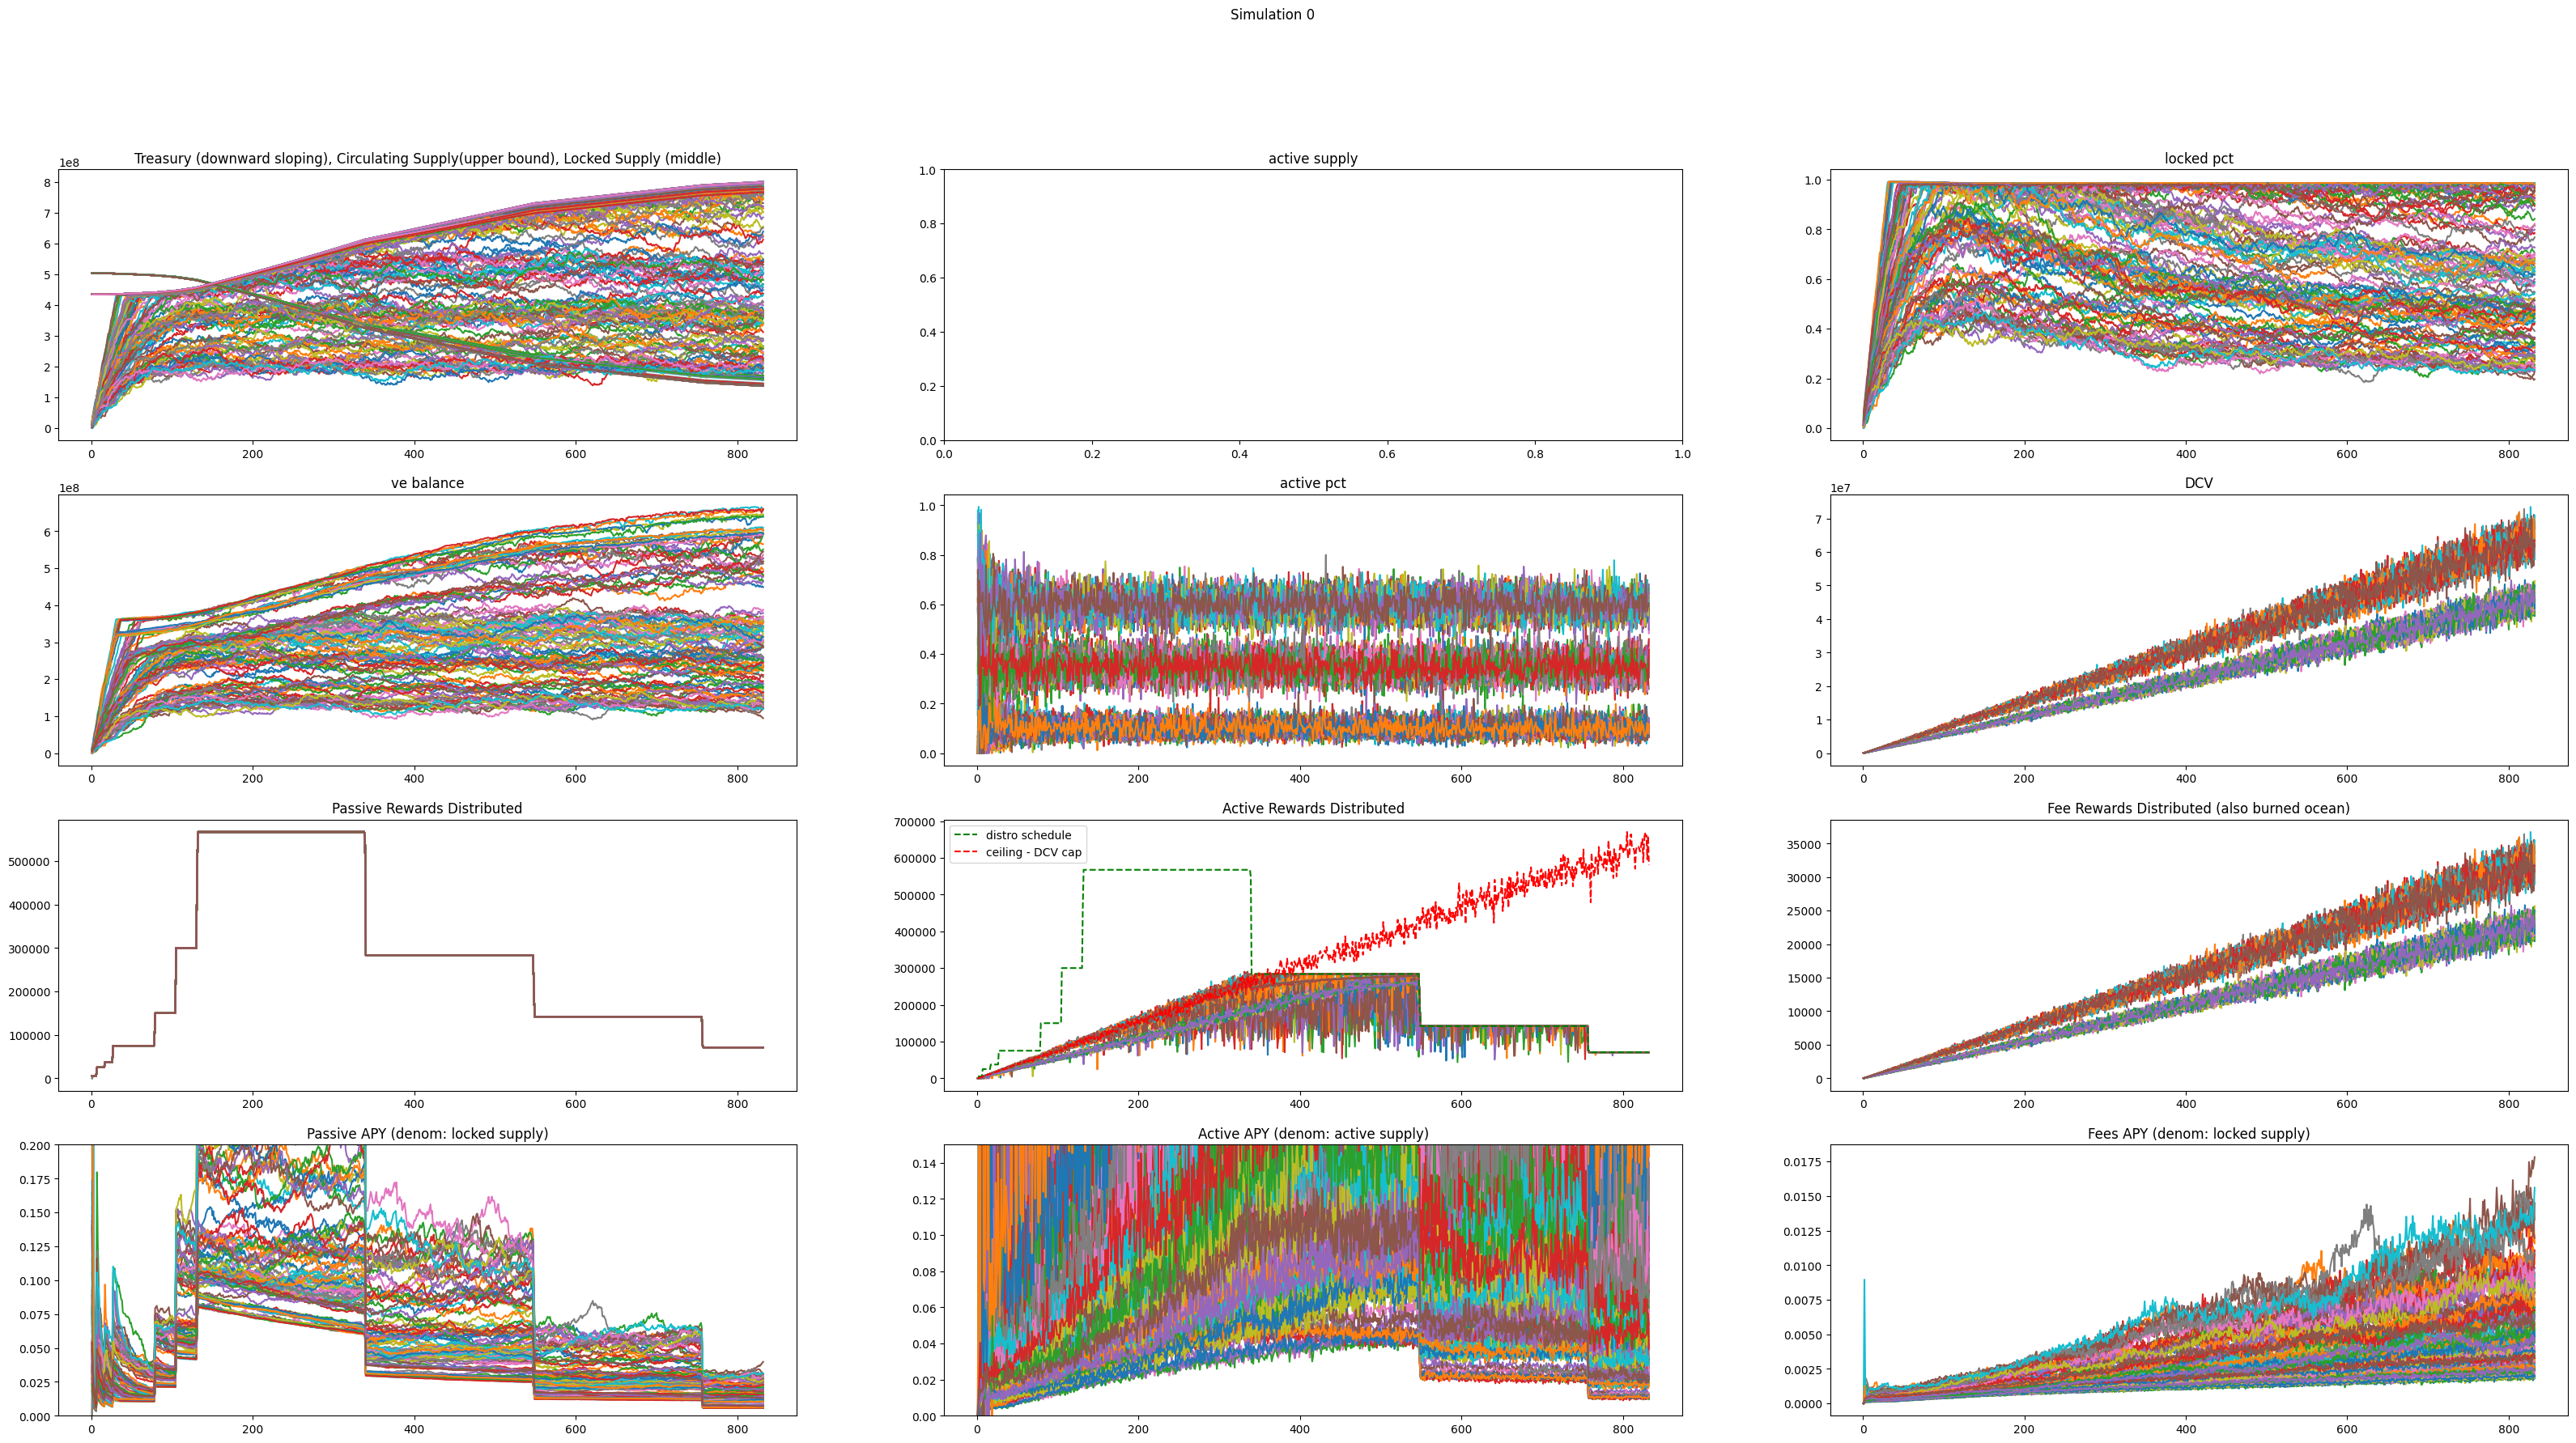

In [59]:
# plot monte carlo runs
for sim in range(0, max(df_p.simulation) + 1):
    df_tmp0 = df_p[df_p.simulation == sim]
    fig, ax = plt.subplots(4,3, figsize=(40,20))
    #for run in range(1, max(df_p.run)+1):
    #    df_tmp = df_tmp0[df_tmp0.run == run]
    for subset in range(0, max(df_p.subset)+1):
        df_tmp = df_tmp0[df_tmp0.subset == subset]
        ax[0,0].plot(df_tmp.timestep, df_tmp.ocean_treasury)
        ax[0,0].plot(df_tmp.timestep, df_tmp.ocean_unlocked_supply + df_tmp.locked_supply)
        ax[0,0].plot(df_tmp.timestep, df_tmp.locked_supply)
        #ax[0,1].plot(df_tmp.timestep, df_tmp.ocean_unlocked_supply)
        ax[0,2].plot(df_tmp.timestep, df_tmp.pct_locked)
        ax[1,0].plot(df_tmp.timestep, df_tmp.ve_balance)
        # could plot avg lock duration??? # driver: locking behavior
        ax[1,1].plot(df_tmp.timestep, df_tmp.active_pct) # driver: voting behavior (uniform random)
        ax[0,1].plot(df_tmp.timestep, df_tmp.active_pct * df_tmp.ve_balance)
        # something for asset-level voting success / distribution # driver: voting behavior (uniform random)
        # x = sort by dataconsumevolume, y = pct of veocean allocated to asset
        ax[1,2].plot(df_tmp.timestep, df_tmp.dcv) # driver: DCV growth rate
        ax[2,0].plot(df_tmp.timestep, df_tmp.rewards_distributed_df_passive) # driver: distribution schedule
        ax[2,1].plot(df_tmp.timestep, df_tmp.rewards_distributed_df_active) # driver: distribution schedule & locking behavior & voting behavior (floor: 0% active or 0% voting success & middle: active_pct/voting success & asset-level success/distribution) & Rewards Function (ceiling: DCV*0.1 or 125%APY, therefore DCV growth rate)
        ax[2,2].plot(df_tmp.timestep, df_tmp.rewards_distributed_fees) # driver: DCV growth rate
        ax[3,0].plot(df_tmp.timestep, df_tmp.Passive_APY) #driver: distro schedule & locking behavior
        ax[3,1].plot(df_tmp.timestep, df_tmp.Active_APY) #driver: distro schedule & locking behavior & voting behavior(active pct & asset-level voting success)
        ax[3,2].plot(df_tmp.timestep, df_tmp.Fees_APY) #driver: DCV growth rate & locking behavior
        #ax[3,3].plot(df_tmp.timestep, df_tmp.Agg_APY)
    
    #ax[2,1].plot(df_tmp0[df_tmp0.run == 1].timestep, df_tmp0[df_tmp0.run == 1].rewards_distributed_df_passive, label='distro schedule', color='green', linestyle='--')
    #ax[2,1].plot(df_tmp0[df_tmp0.run == 1].timestep, df_tmp0[df_tmp0.run == 1].dcv * 0.01, label='ceiling - DCV cap', color='red', linestyle='--')
    ax[2,1].plot(df_tmp0[df_tmp0.subset == 1].timestep, df_tmp0[df_tmp0.subset == 1].rewards_distributed_df_passive, label='distro schedule', color='green', linestyle='--')
    ax[2,1].plot(df_tmp0[df_tmp0.subset == 1].timestep, df_tmp0[df_tmp0.subset == 1].dcv * 0.01, label='ceiling - DCV cap', color='red', linestyle='--')
    
    ax[0,0].set_title('Treasury (downward sloping), Circulating Supply(upper bound), Locked Supply (middle)')
    ax[0,1].set_title('active supply')
    ax[0,2].set_title('locked pct')
    ax[1,0].set_title('ve balance')
    ax[1,1].set_title('active pct')
    #ax[1,2].set_title('something to show uniform random asset-level voting success / distribution')
    ax[1,2].set_title('DCV')
    ax[2,0].set_title('Passive Rewards Distributed')
    ax[2,1].set_title('Active Rewards Distributed')
    ax[2,2].set_title('Fee Rewards Distributed (also burned ocean)')
    ax[3,0].set_title('Passive APY (denom: locked supply)')
    ax[3,0].set_ylim(0,0.2)
    ax[3,1].set_title('Active APY (denom: active supply)')
    ax[3,1].set_ylim(0,0.15)
    ax[3,2].set_title('Fees APY (denom: locked supply)')
    #ax[3,3].set_title('Agg APY (denom: locked supply)')
    ax[2,1].legend()
    fig.suptitle(f"Simulation {sim}")
    plt.show()

In [9]:
def get_rolling_avg(series,window):
    out=[]
    for i in range(0,len(series)):
        if i<window:
            if i==0:
                out.append(series[i])
            else:
                out.append(np.mean(series[:i]))
        else:
            out.append(np.mean(series[i-window:i]))
    return out

#def get_rolling_avg(series_num, series_denom1, series_denom2,window):
#    out=[]
#    for i in range(0,len(series)):
#        if i<window:
#            if i==0:
#                out.append(series[i])
#            else:
#                out.append(np.mean(series[:i]))
#        else:
#            out.append(np.mean(series[i-window:i]))
#    return out

In [12]:
# df for avg monte carlo plots (avg APYs across all runs)
df_avg_apy = df_p[['simulation', 'subset', 'timestep', 'rewards_distributed_df_passive', 'rewards_distributed_df_active', 'rewards_distributed_fees', 'locked_supply', 'active_pct', 've_balance']].reset_index(drop=True)
df_avg_apy = df_avg_apy.groupby(['simulation', 'timestep']).mean().reset_index()
#df_avg_apy = df_avg_apy.groupby(['subset', 'timestep']).mean().reset_index()
df_avg_apy['avg_Agg_rewards_distributed'] = df_avg_apy['rewards_distributed_df_passive'] + df_avg_apy['rewards_distributed_df_active'] + df_avg_apy['rewards_distributed_fees']
df_avg_apy['avg_Passive_APY'] = df_avg_apy.apply(lambda x: (1 + x['rewards_distributed_df_passive']/x['ve_balance']) ** 52 - 1 if x['ve_balance'] != 0 else 0, axis=1)
df_avg_apy['avg_Active_APY'] = df_avg_apy.apply(lambda x: (1 + x['rewards_distributed_df_active']/(x['active_pct']*x['ve_balance'])) ** 52 - 1 if x['ve_balance'] != 0 and x['active_pct'] != 0 else 0, axis=1)
df_avg_apy['avg_Fees_APY'] = df_avg_apy.apply(lambda x: (1 + x['rewards_distributed_fees']/x['ve_balance']) ** 52 - 1 if x['ve_balance'] != 0 else 0, axis=1)
#df_avg_apy['avg_Agg_APY'] = df_avg_apy.apply(lambda x: (1 + (x['rewards_distributed_df_passive'] + x['rewards_distributed_df_active'] + x['rewards_distributed_fees'])/x['ve_balance']) ** 52 - 1 if x['ve_balance'] != 0 else 0, axis=1)
#df_avg_apy['avg_Agg_APY'] = df_avg_apy.apply(lambda x: ((1 + (x['rewards_distributed_df_passive'] + x['rewards_distributed_fees'])/x['ve_balance']) ** 52 - 1) + x['avg_Active_APY']*x['active_pct'] if x['ve_balance'] != 0 else 0, axis=1)
df_avg_apy['avg_Agg_APY'] = df_avg_apy.apply(lambda x: (x['avg_Passive_APY'] + x['avg_Fees_APY'] + x['avg_Active_APY']*x['active_pct']), axis=1)


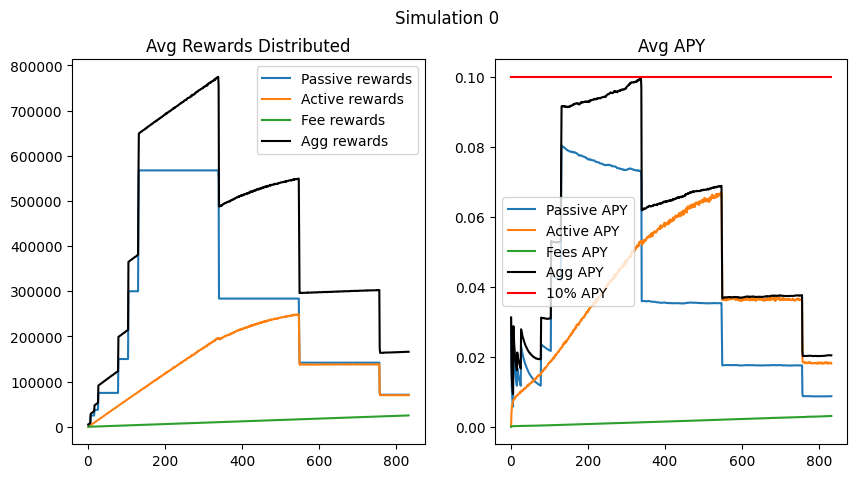

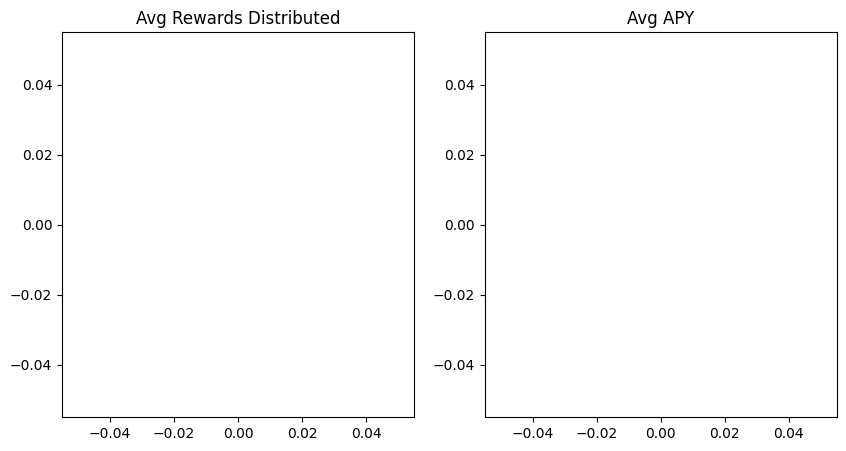

In [11]:
def f(x):
    return x-x+0.1 

weeks = 4

for sim in range(0, max(df_p.simulation) + 1):
    df_tmp = df_avg_apy[df_avg_apy.simulation == sim]
#for subset in range(0, max(df_p.subset)+1):
#    df_tmp = df_avg_apy[df_avg_apy.subset == subset]
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    #ax[0].plot(df_avg_apy.timestep, df_avg_apy.locked_supply, label='Locked Supply')
    ax[0].plot(df_tmp.timestep, df_tmp.rewards_distributed_df_passive, label='Passive rewards')
    ax[0].plot(df_tmp.timestep, df_tmp.rewards_distributed_df_active, label='Active rewards')
    #ax[0].plot(df_tmp.timestep, get_rolling_avg(df_tmp.rewards_distributed_df_active, weeks), label='1m avg - Active rewards')
    ax[0].plot(df_tmp.timestep, df_tmp.rewards_distributed_fees, label='Fee rewards')
    ax[0].plot(df_tmp.timestep, df_tmp.avg_Agg_rewards_distributed, label='Agg rewards', color='black')
    ax[1].plot(df_tmp.timestep, df_tmp.avg_Passive_APY, label='Passive APY')
    ax[1].plot(df_tmp.timestep, df_tmp.avg_Active_APY, label='Active APY')
    #ax[1].plot(df_tmp.timestep, get_rolling_avg(df_tmp.avg_Active_APY, weeks), label='1m avg - Active APY')
    ax[1].plot(df_tmp.timestep, df_tmp.avg_Fees_APY, label='Fees APY')
    ax[1].plot(df_tmp.timestep, df_tmp.avg_Agg_APY, label='Agg APY', color='black')
    ax[1].plot(df_tmp.timestep, f(df_tmp.timestep), label='10% APY', color='red')
    ax[0].set_title('Avg Rewards Distributed')
    ax[1].set_title('Avg APY')
    ax[0].legend()
    ax[1].legend()
    fig.suptitle(f"Simulation {sim}")
    plt.show()

fig, ax = plt.subplots(1,2, figsize=(10,5))
#for sim in range(0, max(df_p.simulation) + 1):
#    df_tmp = df_avg_apy[df_avg_apy.simulation == sim]
for subset in range(0, max(df_p.subset)+1):
    df_tmp = df_avg_apy[df_avg_apy.subset == subset]
    ax[0].plot(df_tmp.timestep, df_tmp.avg_Agg_rewards_distributed, label=f'sim{sim} Agg rewards')
    ax[1].plot(df_tmp.timestep, df_tmp.avg_Agg_APY, label=f'sim{sim} Agg APY')
ax[0].set_title('Avg Rewards Distributed')
ax[1].set_title('Avg APY')
#ax[0].legend()
#ax[1].legend()
plt.show()


949310.498104578

50000.0

19087612.139721323

-19082000
0.0006469238098250432
480918000.0
935298606.9860661
5612.139721322805


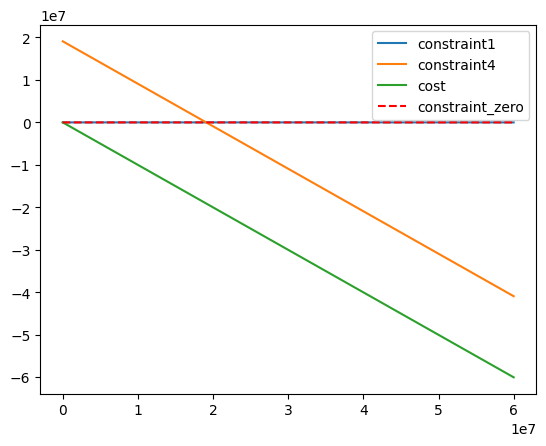

0.8338763045905534